**1. Necessary Imports and dependancies**

In [34]:
!pip install meteostat

In [92]:
import pandas as pd
from meteostat import Point, Daily
from datetime import datetime

**2. LOAD the orders data**

In [93]:
orders_dataset_path = 'data/Boxes.csv'
orders = pd.read_csv(orders_dataset_path)
print(f"Size of dataset = {orders.shape}")
orders.head()

Size of dataset = (2000, 5)


,box_id,delivery_date,Cool Pouch Size,Box Size,postcode
0,GB231,19/02/2022 00:00,M,L,CH624SX
1,GB1481,20/02/2022 00:00,M,M,LS178RS
2,GB1681,20/02/2022 00:00,M,M,CO27LR
3,GB1104,20/02/2022 00:00,S,M,EH177ES
4,GB1343,21/02/2022 00:00,L,L,IP84FA


In [95]:
# change dtype of delivery_date column to date type
orders['delivery_date'] = pd.to_datetime(orders['delivery_date'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   box_id           2000 non-null   object        
 1   delivery_date    2000 non-null   datetime64[ns]
 2   Cool Pouch Size  2000 non-null   object        
 3   Box Size         2000 non-null   object        
 4   postcode         2000 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 78.2+ KB


In [96]:
# Add a column to the dataset to store the number of ice-packs required
orders['num_ice_packs'] = 0
orders.head()

,box_id,delivery_date,Cool Pouch Size,Box Size,postcode,num_ice_packs
0,GB231,2022-02-19,M,L,CH624SX,0
1,GB1481,2022-02-20,M,M,LS178RS,0
2,GB1681,2022-02-20,M,M,CO27LR,0
3,GB1104,2022-02-20,S,M,EH177ES,0
4,GB1343,2022-02-21,L,L,IP84FA,0


**3. Read INPUT dataset for temperature ranges associated with the number of ice packs**

In [97]:
temperature_bands_path = 'data/Temperature_bands.csv'
temp_bands = pd.read_csv(temperature_bands_path)
print(f"Size of Temperature bands dataset = {temp_bands.shape}")
temp_bands

Size of Temperature bands dataset = (7, 5)


,temperature_min,temperature_max,S,M,L
0,-10,4,1,1,1
1,4,10,1,2,2
2,10,16,2,3,3
3,16,19,2,3,4
4,19,24,3,4,5
5,24,30,4,5,6
6,30,35,5,6,7


**4. Meteostat API to get weather**

In [98]:
from meteostat import Stations

stations = Stations()
stations = stations.region('GB')

print('Stations in United Kingdom:', stations.count())

Stations in United Kingdom: 177


In [99]:
UK_lat = 51.509865
UK_long = -0.118092

stations = Stations()
stations = stations.nearby(UK_lat, UK_long)
station = stations.fetch(1)

# Print DataFrame
station

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
03779,London Weather Centre,GB,ENG,03779,EGRB,51.5167,-0.1167,5.0,Europe/London,1992-04-01,2010-02-01,1992-04-03,2010-01-31,2006-01-01,2009-01-01,766.097374


In [100]:
UK_weath_station_ID = '03779'

# Get data for time period
start = datetime(2021, 7, 19)
end = datetime(2021, 7, 19)
data = Daily(UK_weath_station_ID, start, end)
data = data.fetch()
data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2021-07-19,22.5,17.2,27.9,NaN,NaN,182.0,8.4,24.1,1021.5,NaN


**5. Iterate over the dataset and Calculate the number of ice packs required**

In [182]:
def get_packs_count(temp_bands,temp, size):

    # iterate over the temperature bands
    for i, row in temp_bands.iterrows():
        if temp >= row['temperature_min'] and temp <= row['temperature_max']:
            return row[size]

TEMP = []
for i,order in orders.iterrows():
    
    # get the year, month and construct date in required format for API
    year, month, day = int(order['delivery_date'].strftime('%Y')),int(order['delivery_date'].strftime('%m')),int(order['delivery_date'].strftime('%d'))
    start_date = datetime(year,month,day)
    # get temperature for the specific date
    temp = Daily(UK_weath_station_ID, start_date, start_date).fetch().tavg[0]
    TEMP.append(temp)
    size = order['Cool Pouch Size']
    
    orders.at[i,'num_ice_packs'] = get_packs_count(temp_bands,temp,size)
    
    
orders.head()

,box_id,delivery_date,Cool Pouch Size,Box Size,postcode,num_ice_packs
0,GB231,2022-02-19,M,L,CH624SX,2
1,GB1481,2022-02-20,M,M,LS178RS,2
2,GB1681,2022-02-20,M,M,CO27LR,2
3,GB1104,2022-02-20,S,M,EH177ES,1
4,GB1343,2022-02-21,L,L,IP84FA,2


In [184]:
orders.num_ice_packs.value_counts()

2    1466
1     534
Name: num_ice_packs, dtype: int64

**6. Visualisations**

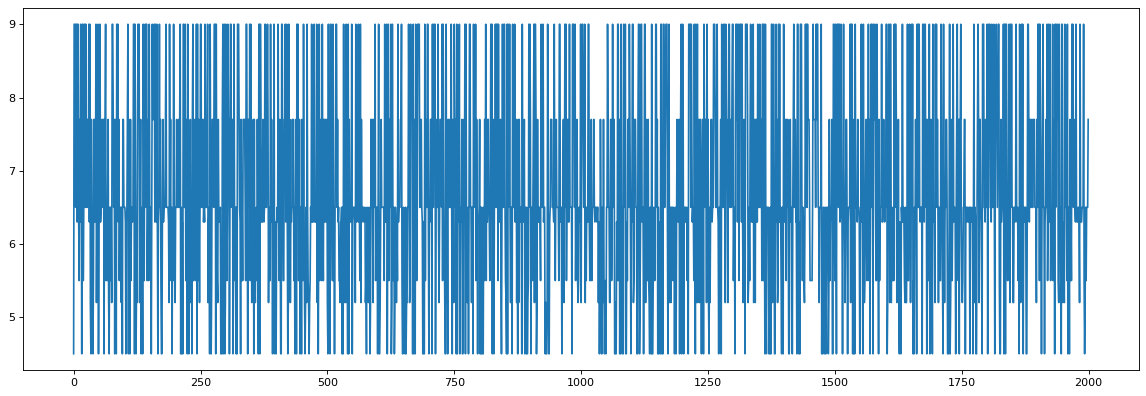

In [185]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(18, 6), dpi=80)
plt.plot(TEMP)

In [186]:
max(TEMP),min(TEMP)

(9.0, 4.5)

**For the given orders dataset the temperature ranges between 4.5-9.0 C**

In [187]:
orders['Cool Pouch Size'].value_counts()

M    1155
S     534
L     311
Name: Cool Pouch Size, dtype: int64

**7. Export to CSV**

In [189]:
orders.to_csv('out.csv',index=False)